# Give Me Some Credit

https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from sklearn.model_selection import train_test_split, ShuffleSplit
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# submission example
f_df = pd.read_csv('sampleEntry.csv')
f_df.head(3)

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968


In [6]:
train_dataset = pd.read_csv('cs-training.csv')
# making test dataset
test_dataset = pd.read_csv('cs-test.csv') 

train_dataset.rename(columns = {train_dataset.columns[0]: "Id"}, inplace = True)
test_dataset.rename(columns = {test_dataset.columns[0]: "Id"}, inplace = True)

train_dataset.drop(train_dataset[train_dataset.NumberOfDependents>=10].index, inplace = True)
train_dataset.drop(train_dataset[train_dataset.age>=100].index, inplace = True)


all_data = pd.concat([train_dataset, test_dataset], ignore_index=True)
# all_data.rename(columns = {all_data.columns[0]: "Id"}, inplace = True)

print(train_dataset.shape, test_dataset.shape, all_data.shape)

(149980, 12) (101503, 12) (251483, 12)


In [7]:
all_data.columns

Index(['Id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [118]:
all_data.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
# clean outlyers a bit
print(all_data.shape)
all_data['MonthlyIncome'] = all_data['MonthlyIncome'].fillna(all_data.groupby(['NumberOfDependents', 'age']
                                                                             )['MonthlyIncome'].transform('mean'))
all_data['MonthlyIncome'] = all_data['MonthlyIncome'].fillna(all_data['MonthlyIncome'].mean())

all_data['NumberOfDependents'] = all_data['NumberOfDependents'].fillna(
    all_data.groupby(['age'])['NumberOfDependents'].transform('mean')).round(0)
# all_data['NumberOfDependents'] = all_data['NumberOfDependents'].round(0)

(251483, 12)


In [86]:
# all_data.NumberOfDependents.value_counts()

In [222]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251483 entries, 0 to 251482
Data columns (total 12 columns):
Id                                      251483 non-null int64
SeriousDlqin2yrs                        149980 non-null float64
RevolvingUtilizationOfUnsecuredLines    251483 non-null float64
age                                     251483 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    251483 non-null int64
DebtRatio                               251483 non-null float64
MonthlyIncome                           251483 non-null float64
NumberOfOpenCreditLinesAndLoans         251483 non-null int64
NumberOfTimes90DaysLate                 251483 non-null int64
NumberRealEstateLoansOrLines            251483 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    251483 non-null int64
NumberOfDependents                      251483 non-null float64
dtypes: float64(5), int64(7)
memory usage: 23.0 MB


In [95]:
# train_dataset.info()

In [9]:
train_df = all_data[all_data['SeriousDlqin2yrs'].notna()]

# le = LabelEncoder()
# train_df[['SeriousDlqin2yrs']]= le.fit_transform(train_df['SeriousDlqin2yrs'])

test_df = all_data[all_data['SeriousDlqin2yrs'].isna()]
print(train_df.shape, test_df.shape)

(149980, 12) (101503, 12)


# Model stuff

In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['SeriousDlqin2yrs', 'Id'], axis = 1)
                                                    , train_df.SeriousDlqin2yrs, shuffle= True)

num_cols = train_df.drop(['SeriousDlqin2yrs', 'Id'], axis = 1).columns[X_train.dtypes != object].tolist()
# X_train[num_cols].info()

In [9]:
cl = list()
for i in range(65):
    cl.append('col_%s' %i)

X_train_polyed = pd.DataFrame(poly.fit_transform(X_train[num_cols]), columns = cl)
X_test_polyed = pd.DataFrame(poly.fit_transform(X_test[num_cols]), columns = cl)

X_train = X_train.join(X_train_polyed)
X_test = X_test.join(X_test_polyed)

In [10]:
# X_train.columns

In [11]:
train_dataset = Pool(data = X_train#.drop(columns = ['Id']),
                     ,label = y_train.astype(bool),
#                      cat_features=categ_features
                    )

eval_dataset = Pool(data = X_test#.drop(columns = ['Id']),
                     ,label = y_test.astype(bool),
#                     cat_features=categ_features
                   )

In [12]:
cat_model2 = CatBoostClassifier(verbose = 1, eval_metric='AUC', iterations = 3000)

In [13]:
%%time
cat_model2.fit(train_dataset)

Learning rate set to 0.028264
0:	total: 300ms	remaining: 14m 59s
1:	total: 380ms	remaining: 9m 29s
2:	total: 467ms	remaining: 7m 46s
3:	total: 575ms	remaining: 7m 11s
4:	total: 682ms	remaining: 6m 48s
5:	total: 799ms	remaining: 6m 38s
6:	total: 890ms	remaining: 6m 20s
7:	total: 970ms	remaining: 6m 2s
8:	total: 1.06s	remaining: 5m 53s
9:	total: 1.16s	remaining: 5m 47s
10:	total: 1.27s	remaining: 5m 45s
11:	total: 1.38s	remaining: 5m 43s
12:	total: 1.46s	remaining: 5m 35s
13:	total: 1.55s	remaining: 5m 30s
14:	total: 1.63s	remaining: 5m 24s
15:	total: 1.7s	remaining: 5m 17s
16:	total: 1.78s	remaining: 5m 12s
17:	total: 1.86s	remaining: 5m 8s
18:	total: 1.94s	remaining: 5m 4s
19:	total: 2.01s	remaining: 5m
20:	total: 2.09s	remaining: 4m 56s
21:	total: 2.17s	remaining: 4m 54s
22:	total: 2.24s	remaining: 4m 50s
23:	total: 2.31s	remaining: 4m 46s
24:	total: 2.38s	remaining: 4m 43s
25:	total: 2.45s	remaining: 4m 40s
26:	total: 2.54s	remaining: 4m 39s
27:	total: 2.6s	remaining: 4m 36s
28:	tota

In [230]:
dd = {'feat': X_train.columns
      , 'rate': cat_model2.get_feature_importance()}
pd.DataFrame(dd).sort_values(['rate'], ascending = False).head(10)
#     dict('feat': X_train.columns, 'rate': cat_model.get_feature_importance()))

,feat,rate
0,RevolvingUtilizationOfUnsecuredLines,20.895270
2,NumberOfTime30-59DaysPastDueNotWorse,7.824396
1,age,7.390891
6,NumberOfTimes90DaysLate,6.706461
3,DebtRatio,5.968490
4,MonthlyIncome,5.104975
5,NumberOfOpenCreditLinesAndLoans,5.086219
8,NumberOfTime60-89DaysPastDueNotWorse,4.050672
7,NumberRealEstateLoansOrLines,2.751814
33,col_23,1.790565


In [14]:
train_preds = cat_model2.predict(X_train)#.drop(columns = ['Id'])
test_preds = cat_model2.predict(X_test)#.drop(columns = ['Id'])

In [15]:
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(train_preds, y_train)))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(test_preds, y_test)))
# 0.763

Правильность на обучающем наборе: 0.932
Правильность на обучающем наборе: 0.764


In [17]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]), columns = cl)
test_df1 = test_df.join(test_df_polyed).drop(['SeriousDlqin2yrs', 'Id'], axis = 1)

In [41]:
fin_pred_1 = cat_model2.predict_proba(test_df1)[:, 1]

In [45]:
fin_pred_1 = test_dataset[['Id']].join(pd.DataFrame(fin_pred_1, columns = ['Probability']))
fin_pred_1.to_csv('sample_submission1.csv', index = False)
# тот же результат

In [48]:
# fin_pred_1

In [38]:
fin_pred_2 = cat_model2.predict(test_df1)
fin_pred_2[34]

'True'

In [32]:
unique, counts = np.unique(fin_pred_2, return_counts=True)
dict(zip(unique, counts))

{'False': 99141, 'True': 2362}

# adding stacking

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [59]:
estimators = [
#      ('rf', RandomForestClassifier(n_estimators=1000, random_state=42)),
#      ('svr', make_pipeline(StandardScaler(),
#                            LinearSVC(random_state=42))),
    ('cat', CatBoostClassifier(verbose = 1, eval_metric='AUC', iterations = 1500))
 ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=CatBoostClassifier(verbose = 1, eval_metric='AUC', iterations = 1500,
#                                cat_features=categ_features
                                                           ))

In [60]:
%%time
clf.fit(X_train, y_train)#.score(X_test, y_test) 

Learning rate set to 0.053367
0:	total: 63.4ms	remaining: 1m 34s
1:	total: 129ms	remaining: 1m 36s
2:	total: 206ms	remaining: 1m 42s
3:	total: 268ms	remaining: 1m 40s
4:	total: 337ms	remaining: 1m 40s
5:	total: 405ms	remaining: 1m 40s
6:	total: 471ms	remaining: 1m 40s
7:	total: 538ms	remaining: 1m 40s
8:	total: 617ms	remaining: 1m 42s
9:	total: 707ms	remaining: 1m 45s
10:	total: 785ms	remaining: 1m 46s
11:	total: 856ms	remaining: 1m 46s
12:	total: 940ms	remaining: 1m 47s
13:	total: 1.01s	remaining: 1m 47s
14:	total: 1.08s	remaining: 1m 47s
15:	total: 1.14s	remaining: 1m 45s
16:	total: 1.2s	remaining: 1m 45s
17:	total: 1.29s	remaining: 1m 46s
18:	total: 1.39s	remaining: 1m 48s
19:	total: 1.48s	remaining: 1m 49s
20:	total: 1.54s	remaining: 1m 48s
21:	total: 1.6s	remaining: 1m 47s
22:	total: 1.66s	remaining: 1m 46s
23:	total: 1.74s	remaining: 1m 46s
24:	total: 1.81s	remaining: 1m 46s
25:	total: 1.87s	remaining: 1m 45s
26:	total: 1.97s	remaining: 1m 47s
27:	total: 2.06s	remaining: 1m 48s
2

StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001443C91ECF8>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x000001443C91ECC0>)

In [61]:
train_preds1 = clf.predict(X_train)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
test_preds1 = clf.predict(X_test)#.drop(columns = ['Transported', 'Cabin', 'PassengerId']))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(train_preds1, y_train)))
print('Правильность на обучающем наборе: {:.3f}'.format(roc_auc_score(test_preds1, y_test)))#.astype(bool)

Правильность на обучающем наборе: 0.937
Правильность на обучающем наборе: 0.766


In [62]:
test_df_polyed = pd.DataFrame(poly.fit_transform(test_df[num_cols]), columns = cl)
test_df1 = test_df.join(test_df_polyed).drop(['SeriousDlqin2yrs', 'Id'], axis = 1)

In [63]:
fin_pred_2 = clf.predict_proba(test_df1)[:, 1]

In [64]:
fin_pred_2 = test_dataset[['Id']].join(pd.DataFrame(fin_pred_2, columns = ['Probability']))
fin_pred_2.to_csv('sample_submission2.csv', index = False)
# тот же результат

## Sequential

In [3]:
import tensorflow as tf

In [ ]:
all_data.tail()

In [10]:
train_df = all_data[all_data['SeriousDlqin2yrs'].notna()]

# le = LabelEncoder()
# train_df[['SeriousDlqin2yrs']]= le.fit_transform(train_df['SeriousDlqin2yrs'])

test_df = all_data[all_data['SeriousDlqin2yrs'].isna()]

In [14]:
train_df.columns

Index(['Id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [17]:
train_df.tail(3)

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149977,149998,0.0,0.246044,58,0,3870.000000,6786.583811,18,0,1,0,0.0
149978,149999,0.0,0.000000,30,0,0.000000,5716.000000,4,0,0,0,0.0
149979,150000,0.0,0.850283,64,0,0.249908,8158.000000,8,0,2,0,0.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['SeriousDlqin2yrs', 'Id'], axis = 1)
                                                    , train_df.SeriousDlqin2yrs, shuffle= True)

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mns = MinMaxScaler()

In [116]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU, Input
from livelossplot import PlotLossesKeras

In [104]:
clf = Sequential()
clf.add(Dense(units = 10, activation= 'relu'
              # , input_shape = (,)
             ))
clf.add(Dense(units = 19, activation= 'relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units = 15, activation= 'relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units = 1, activation= 'sigmoid'))

In [105]:
clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC'])

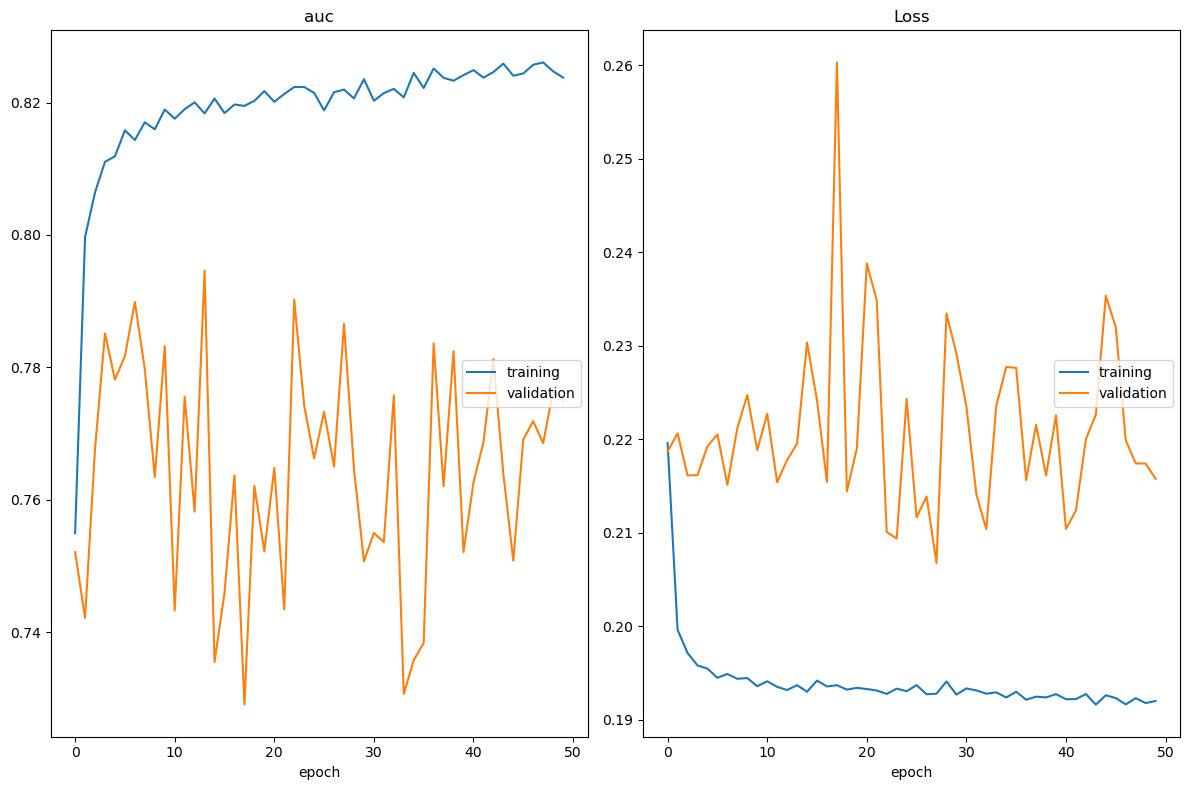

auc
	training         	 (min:    0.755, max:    0.826, cur:    0.824)
	validation       	 (min:    0.729, max:    0.795, cur:    0.775)
Loss
	training         	 (min:    0.192, max:    0.220, cur:    0.192)
	validation       	 (min:    0.207, max:    0.260, cur:    0.216)
11249/11249 [==============================] - 53s 5ms/step - loss: 0.1920 - auc: 0.8238 - val_loss: 0.2158 - val_auc: 0.7750


In [106]:
model_hist = clf.fit(X_train, y_train, epochs=50
                     , batch_size = 10
                    ,validation_data=(X_test, y_test)
                     # ,inp
                     , callbacks=[PlotLossesKeras()]
                    )

In [107]:
score = clf.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21577051281929016
Test accuracy: 0.7749828100204468


In [108]:
clf.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dense_19 (Dense)            (None, 19)                209       
                                                                 
 dropout_4 (Dropout)         (None, 19)                0         
                                                                 
 dense_20 (Dense)            (None, 15)                300       
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 16        
                                                                 
Total params: 635
Trainable params: 635
Non-trainable 

In [109]:
model_hist

In [118]:
test_df = test_df.drop(['SeriousDlqin2yrs', 'Id'], axis = 1)

In [119]:
trans_test_df = sc.transform(test_df)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [114]:
seq_pred = clf.predict(trans_test_df)

3172/3172 [==============================] - 7s 2ms/step


In [115]:
fin_pred_3 = test_dataset[['Id']].join(pd.DataFrame(seq_pred[:,0], columns = ['Probability']))
fin_pred_3.to_csv('sample_submission3.csv', index = False)

In [84]:
print(model_hist.history.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])
